<a href="https://colab.research.google.com/github/abuzarmahmood/pymcon_bayesian_changepoint/blob/master/Bayesian_Changepoint_Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Execute only if executing in Google Colab
if IN_COLAB:
    !pip install --upgrade pip
    !pip install --upgrade pymc==5.9.0 numpyro==0.13.2
    !git clone https://github.com/abuzarmahmood/pymcon_bayesian_changepoint.git
    !mv pymcon_bayesian_changepoint/src .

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import pymc as pm
import pylab as plt
from scipy import stats
import pytensor.tensor as tt
import seaborn as sns
import multiprocessing

In [4]:
from src import get_data, gen_plots

# === Single Poisson Changepoint ===

Parent example: </br>
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb

#### Get, and plot data

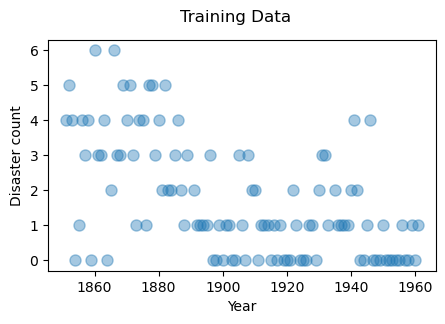

In [34]:
disaster_data, years = get_data.return_simple_data()

plt.figure(figsize=(5,3))
plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");
plt.suptitle('Training Data');

#### Construct simple Poisson Model

In [8]:
with pm.Model() as disaster_model:

    # Uniform Prior on switchpoint location --> We think it can be anywhere
    # between the minimum and maximum times
    # "testval" = Our guess of where it could be, useful if dataset is small
    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    # While statement (switchpoint >= years) is false, use early rate
    # if true, use late rate
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    # Data modelled as poisson distribution with the given rate
    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/home/abuzarmahmood/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/distributions/distribution.py:448: FutureWarning: The `testval` argument is deprecated; use `initval`.
  return super().__new__(cls, name, *args, **kwargs)


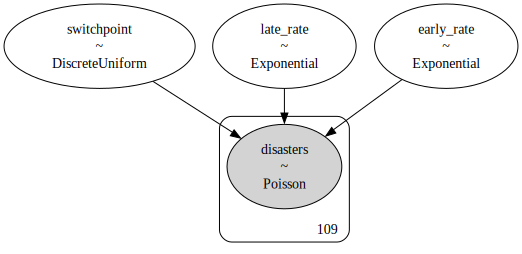

In [9]:
# Plot the graph for the model
pm.model_to_graphviz(disaster_model)

In [10]:
# Run inference on the model
with disaster_model:
    disaster_trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


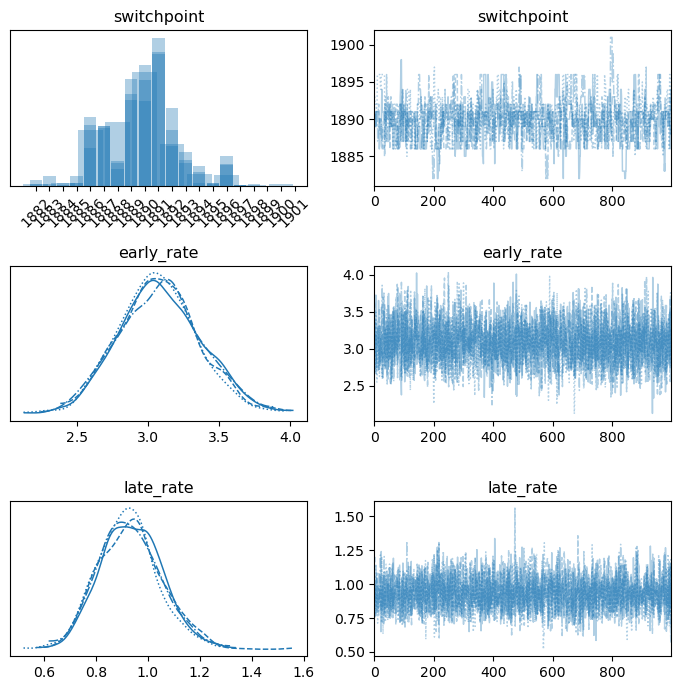

In [14]:
# Plot inferred distributions
ax = pm.plot_trace(disaster_trace, figsize = (7,7));
plt.setp(ax[0,0].xaxis.get_majorticklabels(), rotation=45);
plt.tight_layout()

Sampling: [disasters]


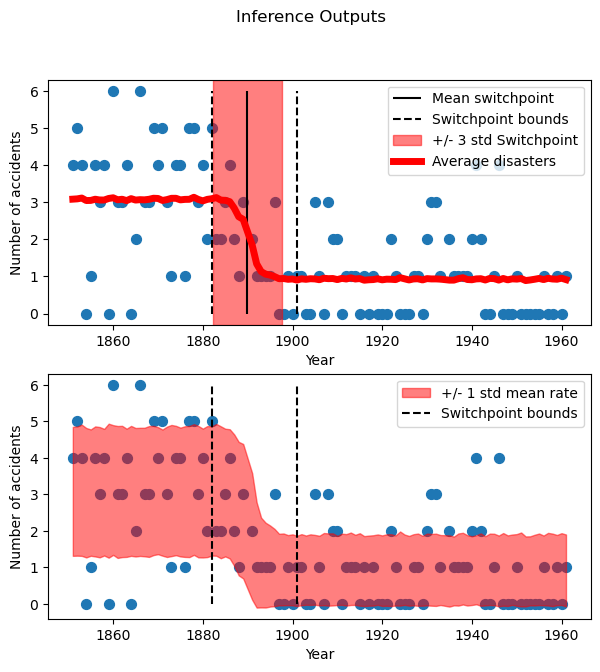

In [35]:
# Sample OBSERVATIONS from the posterior distribution, using the paramters as determined by the trace
gen_plots.gen_simple_plots(years, disaster_data, disaster_model, disaster_trace, figsize = (7,7))

# === Bernoulli Mixture Emissions ===

Related reading: https://medium.com/@abuzar_mahmood/changepoint-detection-for-inhomogeneous-timeseries-mixture-emissions-in-pymc3-2301f76c0064

In [154]:
# Define data params
length = 100
n_states = 3
n_trials = 30
n_components = 2
mixture_probs = [0.3, 0.7]

# Generate test spiking data
true_r, data_vec, component_inds, idx, true_lambda = get_data.return_bernoulli_mixture_data(
    length, n_states, n_trials, n_components, mixture_probs
)
data_vec = data_vec*1

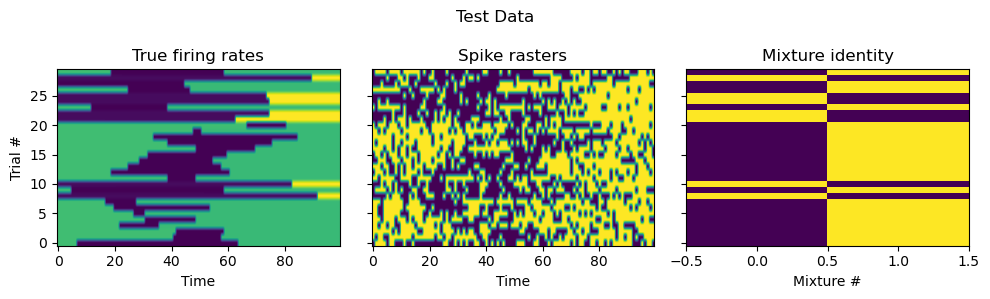

In [155]:
# Visualize test data
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)

ax[0].imshow(true_r,aspect='auto',origin='lower');
ax[1].imshow(data_vec,aspect='auto',origin='lower');

plot_components = np.zeros((n_trials, n_components))
plot_components[np.where(1-component_inds)[0],0] = 1
plot_components[np.where(component_inds)[0],1] = 1
ax[2].imshow(plot_components, aspect='auto',origin='lower');

fig.suptitle('Test Data');
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[2].set_xlabel('Mixture #')
ax[0].set_ylabel('Trial #')
ax[0].set_title('True firing rates');
ax[1].set_title('Spike rasters');
ax[2].set_title('Mixture identity');
plt.tight_layout()

In [156]:
with pm.Model() as model:
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    w = pm.Dirichlet('w', a=alpha_w, shape = (n_trials,n_components))

    alphas = pm.HalfCauchy('alphas',100,shape=(n_components,n_states))
    betas = pm.HalfCauchy('betas',100,shape=(n_components,n_states))
    
    lambdas = pm.Beta('lambdas', alphas, betas, shape=(n_components,n_states))
    
    # clust0_lambda = pm.math.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
    #                          pm.Beta('l01',alphas[0,1], betas[0,1]),
    #                          pm.Beta('l02',alphas[0,2], betas[0,2])])
    # clust1_lambda = pm.math.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
    #                          pm.Beta('l11',alphas[1,1], betas[1,1]),
    #                          pm.Beta('l12',alphas[1,2], betas[1,2])])
    # lambdas = pm.math.stack([clust0_lambda,clust1_lambda])

     #################################################
    a = pm.HalfCauchy('a_tau', 3., shape = n_states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = n_states - 1)

    even_switches = np.linspace(0,1,n_states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b,
                         shape = (n_trials,n_states-1))

    tau = pm.Deterministic('tau',
            idx.min() + (idx.max() - idx.min()) * tau_latent)

    #################################################

    weight_stack = pm.math.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = (n_trials, n_components, length)
    weight_stack = pm.math.concatenate(
        [np.ones(
            (weight_stack_shape[0],1,weight_stack_shape[-1])
            ),weight_stack],
        axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = pm.math.concatenate(
        [inverse_stack,
         np.ones(
            (weight_stack_shape[0],1,weight_stack_shape[-1])
            )
         ],
        axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    #################################################
    selected_lambdas = pm.math.dot(w,lambdas)[:,:,np.newaxis]
    lambda_ = pm.math.sum(selected_lambdas*weight_stack,axis=1)
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

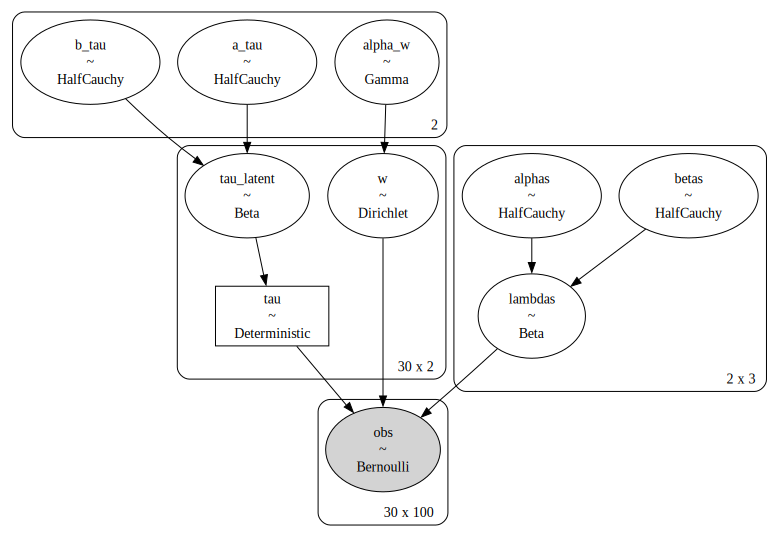

In [157]:
pm.model_to_graphviz(model)

In [158]:
with model:
    trace = pm.sample(nuts_sampler="numpyro", chains = 4, cores = 4)

Compiling...
Compilation time =  0:00:14.396469
Sampling...


Compiling.. :   0%|                                                      | 0/2000 [00:00<?, ?it/s]

  0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                      | 0/2000 [00:00<?, ?it/s]


  0%|                                                                    | 0/2000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                      | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                   | 0/2000 [00:09<?, ?it/s]


Running chain 1:   0%|                                                   | 0/2000 [00:09<?, ?it/s]


Running chain 3:   5%|██                                       | 100/2000 [00:11<00:46, 40.58it/s]

Running chain 1:   5%|██                                       | 100/2000 [00:14<01:29, 21.30it/s]


Running chain 0:   5%|██                                       | 100/2000 [00:16<02:16, 13.87it

Sampling time =  0:02:20.938815
Transforming variables...
Transformation time =  0:00:00.432784


In [193]:
from importlib import reload
reload(gen_plots)

<module 'src.gen_plots' from '/media/bigdata/projects/pymcon_bayesian_changepoint/async_notebook/src/gen_plots.py'>

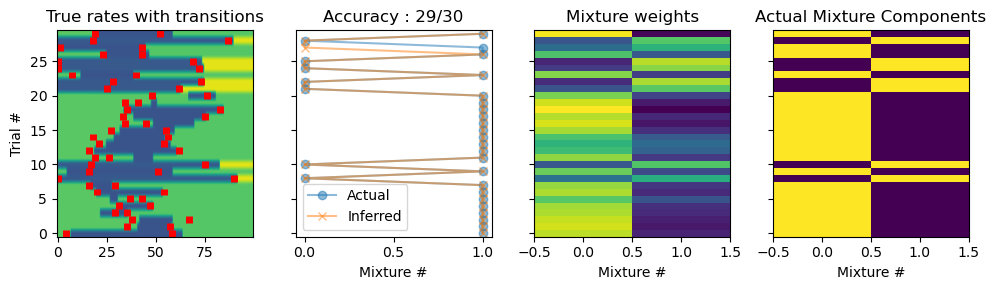

In [194]:
flip_emissions = gen_plots.gen_bernoulli_main_plot(
    trace,
    component_inds,
    n_trials,
    true_r,
    figsize = (10,3),
)

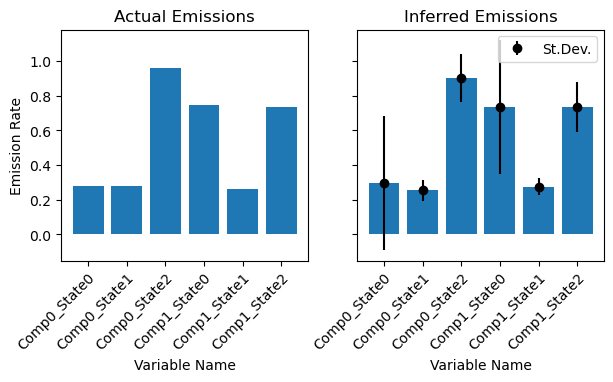

In [195]:
gen_bernoulli_emissions_plot(
    trace,
    n_states,
    n_components,
    flip_emissions,
    true_lambda = true_lambda,
    figsize = (7,3),
)

# === Dirichlet Process Changepoint ===

Related reading: https://medium.com/@abuzar_mahmood/probabilistically-determining-the-number-of-components-for-unsupervised-learning-e1c3c4a82082

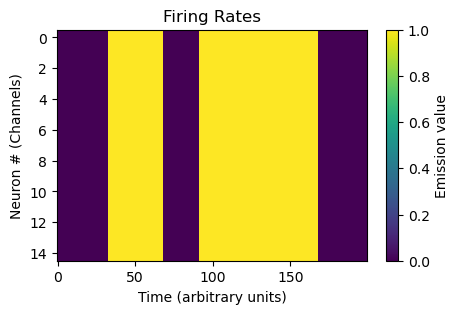

In [22]:
# Max number of states in the model
max_states = 15

# Some poisson spiking
length = 200
n_states = 5
n_neurons = 15

true_r, true_tau, true_lambda = get_data.return_dirichlet_process_data(length, n_states, n_neurons, seesaw_emissions=True)

fig,ax = plt.subplots(figsize = (5,3))
im = ax.imshow(true_r,aspect='auto', interpolation='nearest')
plt.colorbar(im, label = 'Emission value')
ax.set_xlabel('Time (arbitrary units)');
ax.set_ylabel("Neuron # (Channels)");
ax.set_title('Firing Rates');

In [23]:
def stick_breaking(beta):
    portion_remaining = pm.math.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [24]:
# Index vector timebins in data
idx = np.arange(length)

with pm.Model() as dpp_model:

    # ===================
    # Emissions Variables
    # ===================
    lambda_latent = pm.Normal('lambda',
                    mu = 0, sigma = 10,
                    shape = (n_neurons, max_states))

    # =====================
    # Changepoint Variables
    # =====================

    # Hyperpriors on alpha
    a_gamma = pm.Gamma('a_gamma',10,1)
    b_gamma = pm.Gamma('b_gamma',1.5,1)

    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', a_gamma, b_gamma)

    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = max_states)

    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))

    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * length)[:-1])

    # Weight stack to assign lambda's to point in time
    weight_stack = pm.math.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = pm.math.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = pm.math.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    # Create timeseries for latent variable (mean emission)
    lambda_ = pm.Deterministic('lambda_',
                               tt.tensordot(
                                   lambda_latent,
                                   weight_stack,
                                   axes=(1,0)
                               )
                              )

    # Likelihood for observations
    observation = pm.Normal("obs", mu = lambda_, sigma = 0.1, observed=true_r)

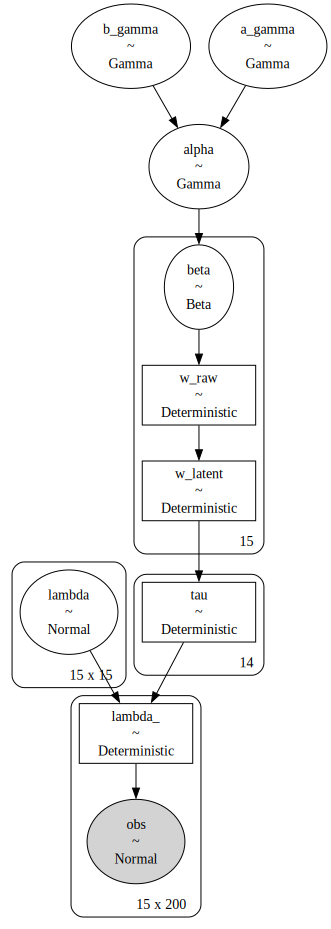

In [25]:
pm.model_to_graphviz(dpp_model)

In [26]:
n_chains = 50
n_samples = 10000
samples_per_chain = n_samples // n_chains

with dpp_model:
    dpp_trace = pm.sample(
                        nuts_sampler="numpyro",
                        tune = samples_per_chain,
                        draws = samples_per_chain,
                        target_accept = 0.95,
                        chains = n_chains,
                        cores = multiprocessing.cpu_count()
                        )

Only 200 samples in chain.
/home/abuzarmahmood/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:27.815123
Sampling...


Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]

  0%|                                                                                      | 0/400 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]


  0%|                                                                                      | 0/400 [00:00<?, ?it/s]


Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]



  0%|                                                                                      | 0/400 [00:00<?, ?it/s]



Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]




  0%|                                                                                      | 0/400 [00:00<?, ?it/s]




Compiling.. :   0%|                                 

Sampling time =  0:01:21.143950
Transforming variables...
Transformation time =  0:00:01.288922


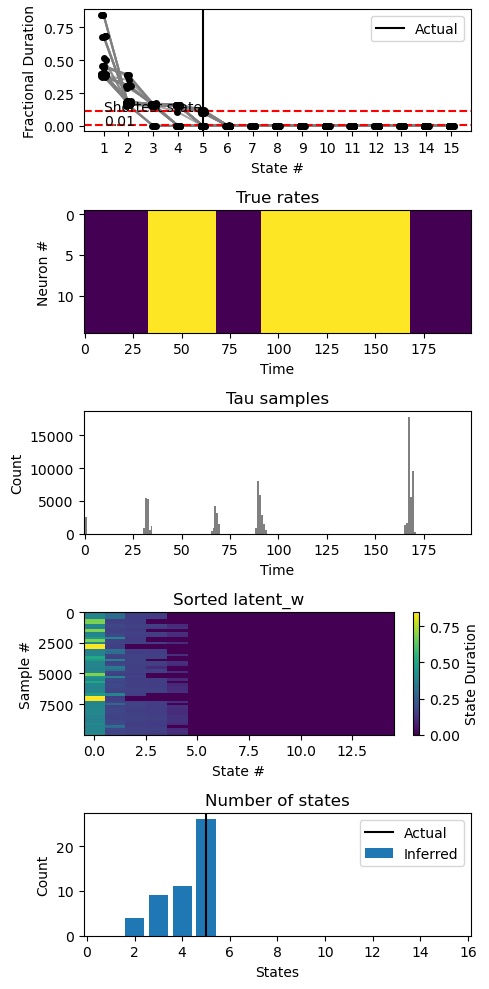

In [47]:
gen_plots.gen_dirichlet_plots(dpp_trace, true_r, n_chains, true_tau, length, n_states, max_states, figsize = (5,10))